# Credit Card PTB by TF Agent DQN

In [1]:
import os
import sys
curr_folder = globals()['_dh']

os.chdir(os.path.join(curr_folder[0], '..'))
sys.path.append(os.path.join(curr_folder[0], '..'))
sys.path.append(os.path.join(curr_folder[0], '../marketing_rl'))

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tf_agents.utils.common as common
from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.networks.q_network import QNetwork
from tf_agents.metrics import tf_metrics
from tf_agents.environments import tf_py_environment
from tf_agents.replay_buffers import TFUniformReplayBuffer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_curve, roc_auc_score
from marketing_rl.environment.biclass_tf_env import BiClassTFEnv, EnvMode

## Load Data

In [3]:
data_path = 'data/Credit Card Lead Prediction/train.csv'
df = pd.read_csv(data_path)
print('total data size is', df.shape[0])

total data size is 245725


## Preparation

### Prep Data

In [4]:
label_col = 'Is_Lead'
index_col = 'ID'
feat_cols = ['Gender', 'Age', 'Region_Code', 'Occupation', 'Channel_Code',
             'Vintage', 'Credit_Product', 'Avg_Account_Balance', 'Is_Active']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(df[feat_cols], df[label_col], random_state=0, test_size=0.3, shuffle=True)
print('train size is', X_train.shape[0])
print('test size is', X_test.shape[0])
print('train positive {}, train negative {}'.format(sum(y_train==1),sum(y_train==0)))

train size is 172007
test size is 73718
train positive 40818, train negative 131189


In [6]:
numer_feats = ['Age', 'Vintage', 'Avg_Account_Balance']
numer_transformer = StandardScaler()


binary_feats = ['Is_Active', 'Credit_Product']
binary_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="constant", fill_value='No')), ("ordinal", OrdinalEncoder())]
)

cat_feats = ['Gender', 'Region_Code', 'Occupation', 'Channel_Code']
cat_transformer = OneHotEncoder(handle_unknown='ignore')

transformer = ColumnTransformer(
    transformers=[
        ("num", numer_transformer, numer_feats),
        ("ordinal", binary_transformer, binary_feats),
        ("cat", cat_transformer, cat_feats)
    ], sparse_threshold = 0
)

In [7]:
X_train_t = transformer.fit_transform(X_train)
X_test_t = transformer.transform(X_test)

In [8]:
pos_neg_ratio = sum(y_train==1)/sum(y_train==0)
print('[train] positive sample to negative sample is', pos_neg_ratio)

[train] positive sample to negative sample is 0.3111388912180137


### Prep Environment

In [9]:
train_data_x = np.array(X_train_t)
train_data_y = np.array(y_train)

In [10]:
train_env = BiClassTFEnv(data_x=train_data_x, data_y=train_data_y, pos_neg_ratio=pos_neg_ratio, early_stop=10)
train_tf_env = tf_py_environment.TFPyEnvironment(train_env)

## Agent Initialization

In [11]:
# define parameters
fc_layers = (64,)
learning_rate = 1e-4
batch_size = 128
replay_buffer_capacity = 100000

num_iterations = 3000

log_interval = 200
eval_interval = 1000



In [12]:
# q network
q_net = QNetwork(
    input_tensor_spec = train_tf_env.observation_spec(),
    action_spec = train_tf_env.action_spec(),
    fc_layer_params = fc_layers,
)

optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)
train_step_counter = tf.compat.v2.Variable(0)
global_step = tf.compat.v1.train.get_or_create_global_step()

# dqn agent
agent = dqn_agent.DqnAgent(
    time_step_spec = train_tf_env.time_step_spec(),
    action_spec = train_tf_env.action_spec(),
    q_network = q_net,
    optimizer = optimizer,
    td_errors_loss_fn = common.element_wise_squared_loss,
    train_step_counter = train_step_counter,
    emit_log_probability = True
)
agent.initialize()


2022-06-07 11:12:34.706327: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Agent Training

In [13]:
# initiate replay buffer for training
replay_buffer = TFUniformReplayBuffer(
    data_spec = agent.collect_data_spec,
    batch_size = train_tf_env.batch_size,
    max_length = replay_buffer_capacity,
)
print("Batch Size: {}".format(train_env.batch_size))

replay_observer = [replay_buffer.add_batch]

# policy
eval_policy = agent.policy
collect_policy = agent.collect_policy


Batch Size: None


In [23]:
dataset = replay_buffer.as_dataset(
    num_parallel_calls = 3, 
    sample_batch_size = batch_size,
    num_steps = 2
).prefetch(3)

date_iter = iter(dataset)

In [24]:
metrics = [
    tf_metrics.NumberOfEpisodes(),
    tf_metrics.EnvironmentSteps(),
    tf_metrics.AverageReturnMetric(),
    tf_metrics.AverageEpisodeLengthMetric(),
    
]

driver = dynamic_step_driver.DynamicStepDriver(
    env = train_tf_env,
    policy = collect_policy,
    observers = replay_observer + metrics,
)


In [25]:
def compute_avg_return(environment, policy, num_episodes=10):
    print('computing average return for {} episodes'.format(num_episodes))
    total_return = 0.0
    total_step = 0
    for i in range(num_episodes):
        time_step = environment.reset()
        episode_return = 0.0

        while not time_step.is_last():
            action_step = policy.action(time_step)
            time_step = environment.step(action_step.action)
            episode_return += time_step.reward
            total_step += 1
        total_return += episode_return
            
    print(f'total step is {total_step}')
    print(f'total reward is {total_return}')
    avg_return = total_return / num_episodes
    return avg_return.numpy()[0]


In [26]:
agent.train = common.function(agent.train)

In [28]:
time_step = train_tf_env.reset()
episode_len = []
step_len = []
losses = []
returns = []
agent.train_step_counter.assign(0)
for i in range(num_iterations+1):
    time_step, _ = driver.run(time_step)
    
    experience, _ = next(date_iter)
    train_loss = agent.train(experience=experience)
    step = agent.train_step_counter.numpy()

    if step % log_interval == 0:
        print('step = {0}: loss = {1}'.format(step, train_loss.loss))
        episode_len.append(metrics[3].result().numpy())
        step_len.append(step)
        print('Average episode length: {}'.format(metrics[3].result().numpy()))
    
    if step % eval_interval == 0:
        avg_return = compute_avg_return(eval_tf_env, agent.policy, num_eval_episodes)
        print('step = {0}: Average Return = {1}'.format(step, avg_return))
        losses.append(train_loss)
        returns.append(avg_return)

step = 200: loss = 0.2857546806335449
Average episode length: 101.25
step = 400: loss = 0.2813805043697357
Average episode length: 130.22222900390625
step = 600: loss = 0.3240312337875366
Average episode length: 142.6999969482422
step = 800: loss = 0.28743019700050354
Average episode length: 151.0
step = 1000: loss = 0.30310332775115967
Average episode length: 164.5
computing average return for 1 episodes
total step is 73718
total reward is [12018.165]
step = 1000: Average Return = 12018.1650390625
step = 1200: loss = 0.2615489959716797
Average episode length: 174.89999389648438
step = 1400: loss = 0.24516496062278748
Average episode length: 181.6999969482422
step = 1600: loss = 0.2692219913005829
Average episode length: 194.1999969482422
step = 1800: loss = 0.24195602536201477
Average episode length: 194.1999969482422
step = 2000: loss = 0.28554555773735046
Average episode length: 206.60000610351562
computing average return for 1 episodes
total step is 73718
total reward is [12008.408

In [19]:
eval_data_x = np.array(X_test_t)
eval_data_y = np.array(y_test)

eval_env = BiClassTFEnv(data_x=eval_data_x, data_y=eval_data_y, pos_neg_ratio=pos_neg_ratio, mode=EnvMode.TEST)
eval_tf_env = tf_py_environment.TFPyEnvironment(eval_env)


## Evaluation

In [51]:
from tf_agents.trajectories import StepType 

In [78]:
eval_data_x

array([[-1.20490136, -0.86558419,  1.31248727, ...,  0.        ,
         0.        ,  0.        ],
       [-0.73240057, -0.68026878, -0.1643117 , ...,  0.        ,
         0.        ,  0.        ],
       [-1.06990113, -0.86558419, -0.36911084, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.39490001, -0.80381238, -0.76413925, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.34760123, -0.46406746, -0.26182323, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.41510134,  0.61693909,  0.01834165, ...,  1.        ,
         0.        ,  0.        ]])

In [83]:
eval_q_values, _ = agent._q_network(eval_data_x) 
train_q_values, _ = agent._q_network(train_data_x) 

In [86]:
train_fpr, train_tpr, _ = roc_curve(train_data_y, train_q_values[:, 1])
test_fpr, test_tpr, _ = roc_curve(eval_data_y, eval_q_values[:, 1])

train_auc = roc_auc_score(y_train, train_q_values[:, 1])
test_auc = roc_auc_score(y_test, eval_q_values[:, 1])

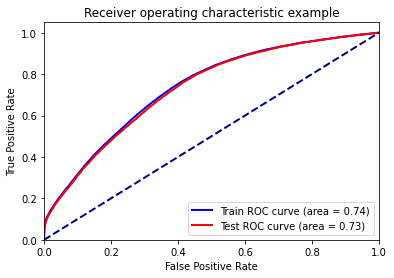

In [87]:
plt.figure()
lw = 2
plt.plot(train_fpr, train_tpr, color="b",lw=lw, label="Train ROC curve (area = %0.2f)" % train_auc)
plt.plot(test_fpr, test_tpr, color="r",lw=lw, label="Test ROC curve (area = %0.2f)" % test_auc)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()